# PSO Fitting Testing

In [4]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

## Do 12-005 S2

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

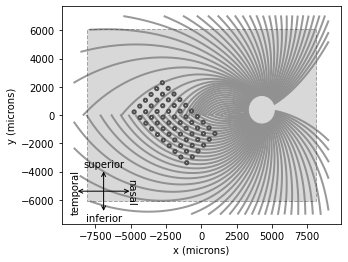

In [13]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.25

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')

data = data[(data['amp1'] == 2) & (data['freq'] == 20)]
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y.iloc[0].shape

estimator = shapes.AxonMapEstimator(implant=implant, model=model, mse_params=['area', 'eccentricity', 'orientation'], loss_fn='r2', scale_features=False)
search_params = {
#     'a5' : (0, 5),
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()

In [ ]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

In [14]:
estimator = shapes.AxonMapEstimator(implant=implant, model=model, mse_params=['area', 'eccentricity', 'orientation'], loss_fn='r2')
search_params = {
#     'a5' : (0, 5),
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)
y_moments = estimator.compute_moments(y)
data[['area', 'eccentricity', 'orientation']] = y_moments
averaged_moments = data.groupby(['amp1', 'freq', 'pdur', 'electrode1'])['area', 'eccentricity', 'orientation'].mean()
x = data[['amp1', 'freq', 'pdur', 'electrode1']].drop_duplicates()

Removing means (['area: 636.53', 'eccentricity: 0.86', 'orientation: 0.01']) 
Scaling standard deviations (['area: 434.34', 'eccentricity: 0.16', 'orientation: 0.95']) to be 1


In [15]:
estimator.score(x, averaged_moments)
opt.fit(x, averaged_moments)
estimator.score(x, averaged_moments)

score:18.747, rho:200.0, lambda:200.0, empty:0, mses:['area:1.1', 'eccentricity:13.8', 'orientation:3.9']
score:803.233, rho:617.3, lambda:1104.7, empty:0, mses:['area:791.0', 'eccentricity:7.7', 'orientation:4.5']
score:7.601, rho:46.3, lambda:1104.0, empty:0, mses:['area:2.7', 'eccentricity:2.4', 'orientation:2.5']
score:75.718, rho:357.3, lambda:64.2, empty:0, mses:['area:25.6', 'eccentricity:46.7', 'orientation:3.5']
score:60.584, rho:329.4, lambda:647.3, empty:0, mses:['area:51.6', 'eccentricity:5.7', 'orientation:3.3']
score:2104.230, rho:895.0, lambda:189.1, empty:0, mses:['area:2050.0', 'eccentricity:50.3', 'orientation:4.0']
score:219.837, rho:458.5, lambda:751.9, empty:0, mses:['area:207.3', 'eccentricity:8.0', 'orientation:4.6']
score:180.879, rho:303.6, lambda:1929.1, empty:0, mses:['area:174.1', 'eccentricity:3.6', 'orientation:3.2']
score:2250.436, rho:912.2, lambda:119.3, empty:0, mses:['area:2195.0', 'eccentricity:51.7', 'orientation:3.8']
score:76.130, rho:346.6, lambd

6.544188038977456

In [ ]:
params1 = estimator.get_params()
params1

In [ ]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
estimator.set_params(**params1)
estimator.fit(x, y)
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample(list(x.index), 10)):
    img = resize(center_image(preds[img_idx] > 0.65), y[img_idx].shape)
    area = np.sum(img)
    axes[plt_idx, 0].imshow(img, cmap="gray")
    props = measure.regionprops(measure.label(img))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (np.sum(y[img_idx]), prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

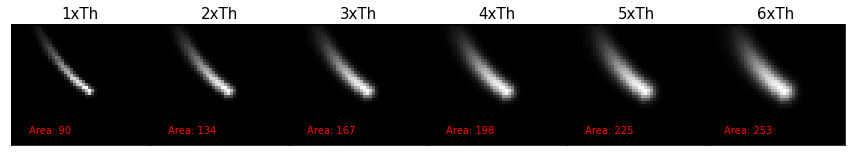

In [6]:
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import ProsthesisSystem, DiskElectrode
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'fontname':'Arial'}

import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(1, 6, sharex=True, sharey=True)#, gridspec_kw={'height_ratios': [2.5, 1, 1]})
fig.subplots_adjust(wspace=0, hspace=-0.35)

amps = [1, 2, 3, 4, 5, 6]
freqs = [5, 10, 20,40, 80, 120]
pdurs_1 = [0.1, 0.5, 1, 5, 10]
pdurs_2 = [.1, 1, 5, 25, 50, 100]
# ticks = [-6.0, -3.0, 0.0, 3.0]
plotborder = 1.5
ticks = []
model = BiphasicAxonMapModel(axlambda=estimator.axlambda, rho=estimator.rho, do_thresholding=False, yrange=(0, 10), xrange=(-6.5, 5))
model.a5 = estimator.a5
model.a6 = estimator.a6
model.build()
implant = ProsthesisSystem(DiskElectrode(0, 1500, 10, 200))

for i, amp in enumerate(amps):
    ax = axes[i]
    fig.sca(ax)
    stim = BiphasicPulseTrain(5, amp, 0.45)
    implant.stim = stim
    percept = model.predict_percept(implant)
    percept.plot(figsize=(11.5 * 1.3, 10 * 1.3))
    ax.set_title("" + str(amp) + "xTh", fontsize=15, **font)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")
#         ax.set_ylabel("Amplitude", fontweight='bold', fontsize=14)
    ax.set_xlabel("")
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_ylim(0, 10)
    area = np.sum(percept.data > (percept.data.max() - percept.data.min()) * 0.1 + percept.data.min())
    ax.annotate("Area: {:d}".format(area), (-5, 1), color='r')

    
fig.show()

### Unstandardized mses

In [4]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features = False
new_y_moments = estimator.compute_moments(y, fit_scaler=False)
estimator.score(x, new_y_moments)

Warning, got different length feature_importances and mse_params. Did you set one manually?
Defaulting to equal weighting
score=11791400626093288.000, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 547970.197', 'M02: 37707208160.562', 'M11: 8851765103.171', 'M12: 175017656640.709', 'M20: 23336645998.738', 'M21: 106765878002.187', 'M22: 1.1791048945841724e+16', 'area: 547970.197', 'eccentricity: 0.229', 'major_axis_length: 1371.235', 'minor_axis_length: 346.584', 'orientation: 1.003']


1.1791400626093288e+16

### Standardized mses

In [6]:
estimator.mse_params = ['moments_central', "area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation"]
estimator.scale_features=True
new_y_moments = estimator.compute_moments(y, fit_scaler=True)
estimator.score(x, new_y_moments)

Removing means (['M00: 560.18', 'M02: 95102.63', 'M11: 24202.46', 'M12: -46893.36', 'M20: 65115.72', 'M21: -50567.79', 'M22: 31353163.63', 'area: 560.18', 'eccentricity: 0.87', 'major_axis_length: 58.04', 'minor_axis_length: 18.48', 'orientation: 0.06']) 
Scaling standard deviations (['M00: 392.19', 'M02: 130835.05', 'M11: 93802.57', 'M12: 416635.68', 'M20: 76773.64', 'M21: 322264.26', 'M22: 102740688.22', 'area: 392.19', 'eccentricity: 0.15', 'major_axis_length: 29.93', 'minor_axis_length: 9.21', 'orientation: 0.94']) to be 1
score=33.902, rho=200.0, lambda=200.0, a5=1.081, a6=-0.353, mses: ['M00: 3.563', 'M02: 2.203', 'M11: 1.006', 'M12: 1.008', 'M20: 3.959', 'M21: 1.028', 'M22: 1.117', 'area: 3.563', 'eccentricity: 9.699', 'major_axis_length: 1.531', 'minor_axis_length: 4.082', 'orientation: 1.143']


33.90164057294065

## Fit size model first

In [8]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

Removing means (['M00: 572.78', 'M02: 118251.72', 'M11: 12787.84', 'M12: -142800.68', 'M20: 80173.9', 'M21: -112306.35', 'M22: 52262131.65']) 
Scaling standard deviations (['M00: 386.2', 'M02: 154667.97', 'M11: 124106.3', 'M12: 1342767.19', 'M20: 94607.6', 'M21: 1143759.61', 'M22: 145068970.21']) to be 1
a5=0.215281, a6=0.730899


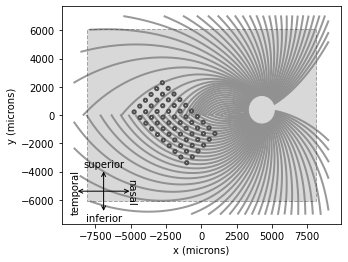

In [9]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()
estimator.fit_size_model(x['amp1'], y)

In [10]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

score:7.697, rho:200.0, lambda:200.0, a5:0.215, a6:0.731, empty:0, mses: ['M00:1.2', 'M02:1.2', 'M11:1.0', 'M12:1.0', 'M20:1.1', 'M21:1.0', 'M22:1.1']
score:210.652, rho:407.5, lambda:617.4, a5:0.215, a6:0.731, empty:0, mses: ['M00:59.7', 'M02:54.0', 'M11:3.2', 'M12:1.9', 'M20:87.2', 'M21:1.4', 'M22:3.2']
score:288597.797, rho:981.6, lambda:1884.7, a5:0.215, a6:0.731, empty:0, mses: ['M00:2378.2', 'M02:74193.7', 'M11:1861.5', 'M12:15104.4', 'M20:79365.5', 'M21:8306.7', 'M22:107387.9']
score:601.907, rho:274.0, lambda:1627.7, a5:0.215, a6:0.731, empty:0, mses: ['M00:53.6', 'M02:219.1', 'M11:79.4', 'M12:25.3', 'M20:128.3', 'M21:31.1', 'M22:65.1']
score:27653.445, rho:725.8, lambda:1469.5, a5:0.215, a6:0.731, empty:0, mses: ['M00:782.2', 'M02:9031.6', 'M11:553.5', 'M12:1171.2', 'M20:9924.4', 'M21:675.5', 'M22:5515.1']
score:54521.815, rho:853.5, lambda:1202.6, a5:0.215, a6:0.731, empty:0, mses: ['M00:1201.4', 'M02:15851.7', 'M11:339.4', 'M12:1239.5', 'M20:23322.3', 'M21:882.7', 'M22:11684

7.603348268616845

In [11]:
params2 = estimator.get_params()
params2

{'rho': 98.49269997747697,
 'axlambda': 668.7223698828682,
 'a0': 2.095,
 'a1': 0.054326,
 'a2': 1.84,
 'a3': 0.2,
 'a4': 3.0986,
 'a5': 0.21528079,
 'a6': 0.730899017304182,
 'a7': 0.54,
 'a8': 0.21,
 'a9': 1.56}

score:7.603, rho:98.5, lambda:668.7, a5:0.215, a6:0.731, empty:0, mses: ['M00:1.3', 'M02:1.2', 'M11:0.8', 'M12:1.0', 'M20:1.2', 'M21:1.0', 'M22:1.1']


7.603348268616845

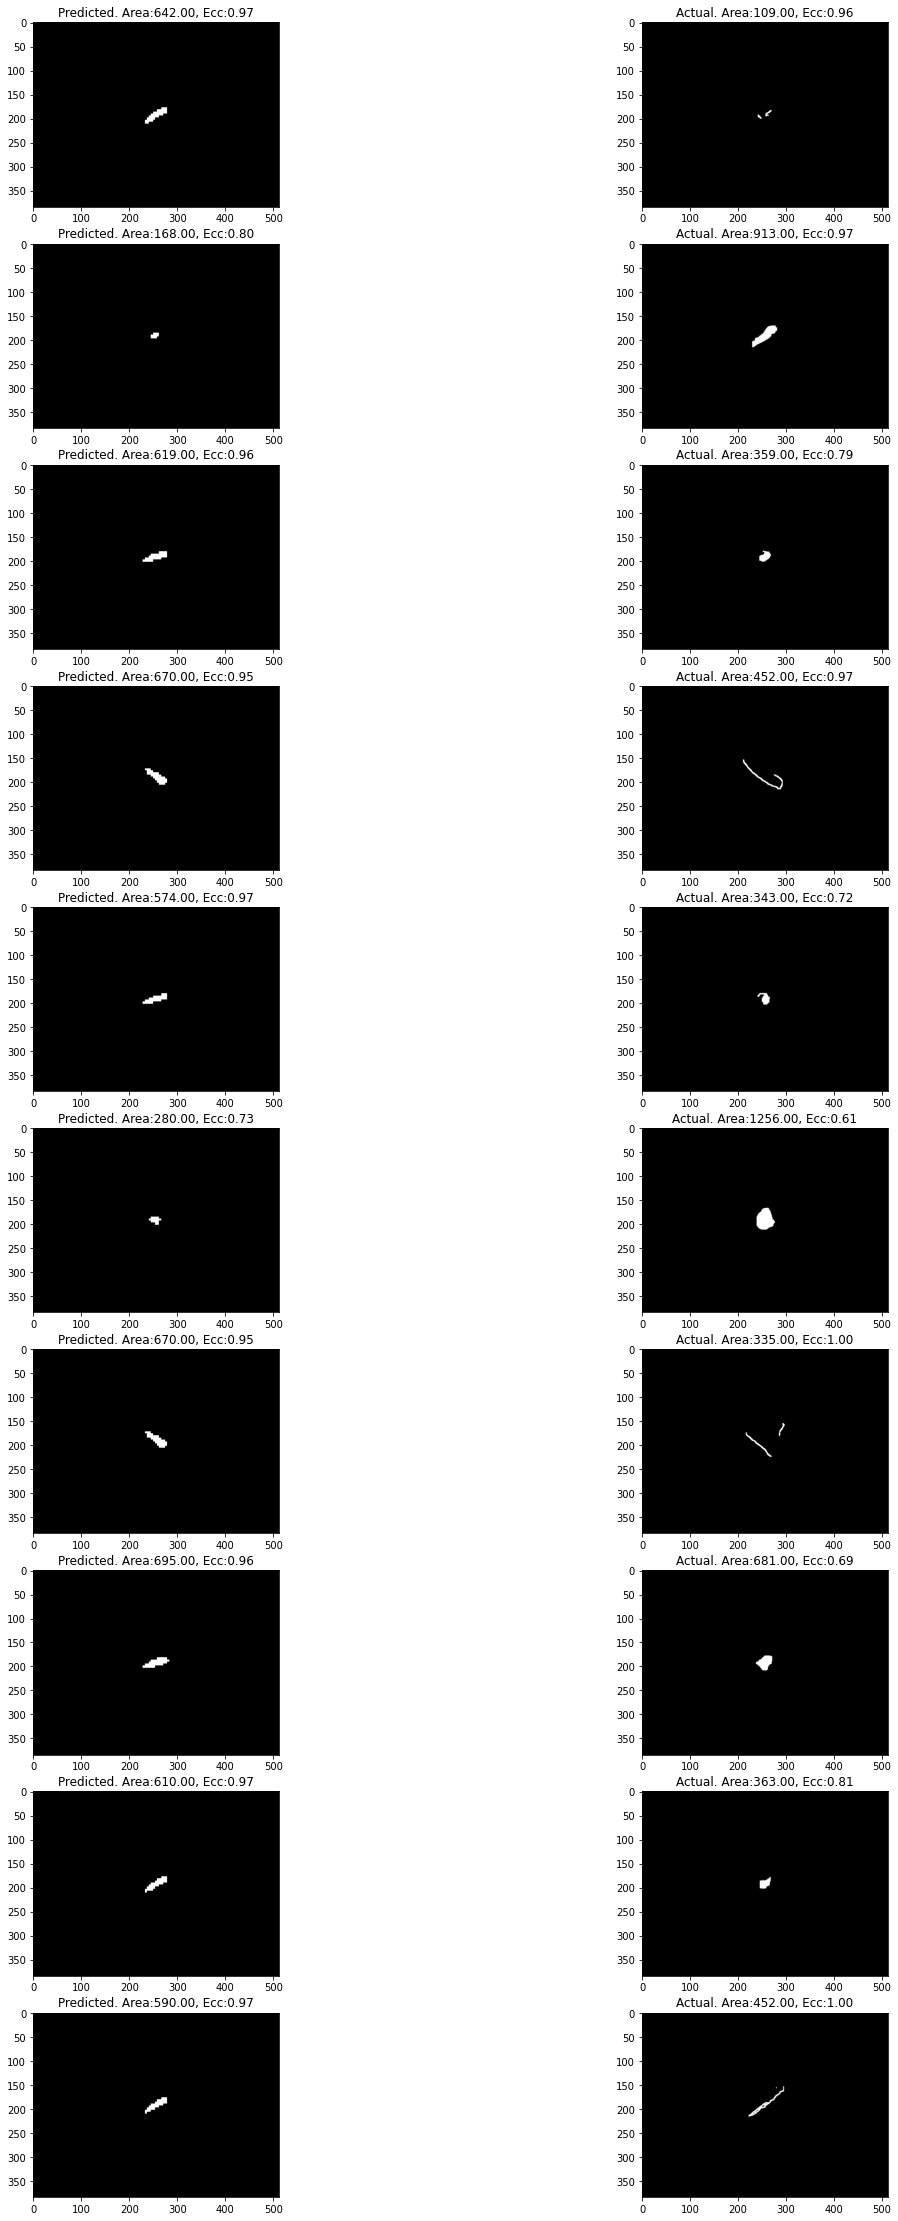

In [12]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
estimator.set_params(**params2)
estimator.fit(x, y)
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    img = resize(center_image(preds[img_idx] > (preds[img_idx].max() - preds[img_idx].min()) * 0.1 + preds[img_idx].min()), y[img_idx].shape)
    area = np.sum(img)
    axes[plt_idx, 0].imshow(img, cmap="gray")
    props = measure.regionprops(measure.label(img))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (np.sum(y[img_idx]), prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

## AxonMap

In [16]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

Removing means (['M00: 572.78', 'M02: 118251.72', 'M11: 12787.84', 'M12: -142800.68', 'M20: 80173.9', 'M21: -112306.35', 'M22: 52262131.65']) 
Scaling standard deviations (['M00: 386.2', 'M02: 154667.97', 'M11: 124106.3', 'M12: 1342767.19', 'M20: 94607.6', 'M21: 1143759.61', 'M22: 145068970.21']) to be 1


<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

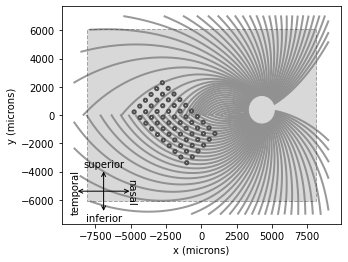

In [17]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.AxonMapEstimator(implant=implant, model=model, resize=True, mse_params=['moments_central'])
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=100, has_loss_function=True)

y_moments = estimator.compute_moments(y)
model.build()
model.plot()
implant.plot()

In [ ]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

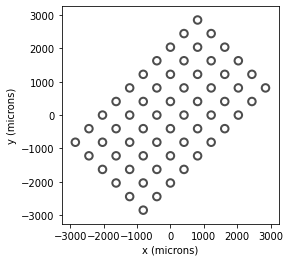

In [13]:
t = ArgusII(rot=45)
t.plot()